In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict

In [3]:
# configure matplotlib
%matplotlib notebook
# %matplotlib inline

In [4]:
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"

In [5]:
from cdi.util.stats_utils import load_statistics

from cdi.util.analysis.plotting import plot_comparison, plot_seaborn_comparison
from cdi.util.analysis.logs import collate_stats

## Analysis setup

### Global settings

In [6]:
data_name = 'fcvae_frey_large_processed'
# exp_seed_key = 'm20190508_d20200325_20200406_20200407'
exp_seed_keys = [
    'm20190508_d20200325_20200406_20200407',
    'm20190508_d2020032511_20200406_20200407',
    'm20190508_d2020032522_20200406_20200407',
    'm20190508_d2020032533_20200406_20200407',
    'm20190508_d2020032544_20200406_20200407',
    'm20190508_d2020032555_20200406_20200407',
    'm20190508_d2020032566_20200406_20200407',
    'm20190508_d2020032577_20200406_20200407',
    'm20190508_d2020032588_20200406_20200407',
    'm20190508_d2020032599_20200406_20200407',
]

### Templates

In [7]:
log_path_template = f'../../trained_models/{data_name}/learning_experiments/{{}}/{{}}/{{}}/logs/{{}}'

## Helpers

In [8]:
def read_experiment_stats(group, model, seed, filename):
    path = log_path_template.format(group, model, seed, filename)
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    return load_statistics(dirpath, filename)

def read_experiment_stats_all_seeds(group, model, filename):
    all_stats = defaultdict(list)
    for exp_seed in exp_seed_keys:
        path = log_path_template.format(group, model, exp_seed, filename)
        filename = os.path.basename(path)
        dirpath = os.path.dirname(path)
        stats = load_statistics(dirpath, filename)
        for k, v in stats.items():
            all_stats[k].append(v)
    
    return all_stats

def read_suite_stats_all_seeds(group, suite, filename):
    return {
        name: read_experiment_stats_all_seeds(group, model, filename)
        for name, model in suite.items()
    }

def read_suite_stats(group, suite, filename, seed):
    return {
        name: read_experiment_stats(group, model, seed, filename)
        for name, model in suite.items()
    }

def read_suite_stats_with_init_all_seeds(group, suite):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats_all_seeds(group, model, 'summary.csv')
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, exp_seed_keys[0], 'init_summary.csv')):
            init_stats = read_experiment_stats_all_seeds(group, model, 'init_summary.csv')
            stats[name]['init'] = init_stats

    return stats

def read_suite_stats_with_init(group, suite, seed):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats(group, model, seed, 'summary.csv')
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, seed, 'init_summary.csv')):
            init_stats = read_experiment_stats(group, model, seed, 'init_summary.csv')
            stats[name]['init'] = init_stats

    return stats

##

def read_all_suite_stats(groups, suite, filename, seed):
    return {
        group: read_suite_stats(group, suite, filename, seed)
        for group in groups
    }


## Learning curve analysis

### Likelihood analysis


#### Log-likelihood vs epoch

In [17]:
suite = {
    'VAE Complete data + MLE $\mathcal{L}(p(x))$': 'fcvae_complete_data',
#     'MICE + MLE': 'fcvae_mice_baseline',
    'MIWAE $\mathcal{L}(p(x_o))$': 'fc_miwae',
    'MVAE $\mathcal{L}(p(x_o))$': 'fc_mvae',
#     'PartialVAE+ $\mathcal{L}(p(x_o))$': 'fc_pvae',
    'HI-VAE $\mathcal{L}(p(x_o))$': 'fc_hivae',
#     'VAE VCDI $\mathcal{L}(p(x))$': 'fcvae_pretrained_svar_cdi',
#     'VAE VCDI (marginalise) $\mathcal{L}(p(x_o))$ K=1': 'fcvae_pretrained_svar_cdi_marginalise',
    
}

##### Single experiment

<IPython.core.display.Javascript object>


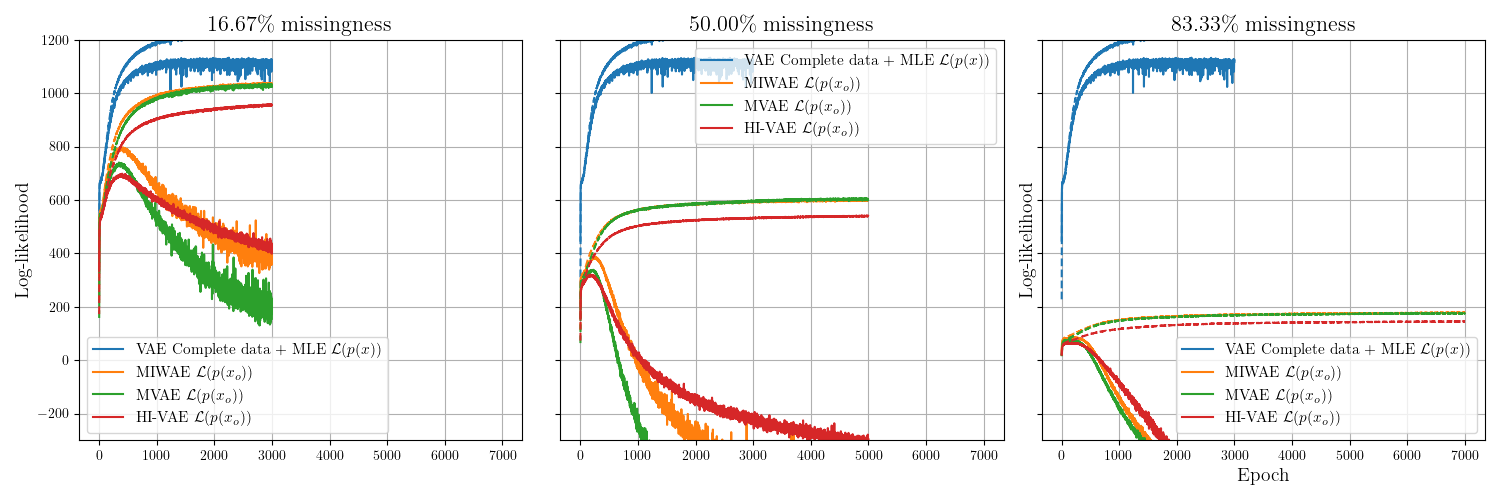

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15, 5))
axes = axes.flatten()
# axes = [axes]
gs = [1, 3, 5]
# gs = [1]
for i, g in enumerate(gs):
    stats = read_suite_stats(group=g, suite=suite, seed=exp_seed_keys[0], filename='summary.csv')

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (0, 2):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    if i in (2, 3):
        xlabel='Epoch'
    else:
        xlabel=None
    
    plot_comparison(axes[i], stats, 
                    x_metric_key='curr_epoch',
                    y_metric_keys=('val_log_lik', 'train_log_lik', 'aug_val_log_lik'),
#                     y_metric_keys=('val_log_lik',),  
# #                     y_metric_keys=('train_log_lik', 'train_entropy', 'val_log_lik'),
                    err_keys=(None, None, None),
#                     err_keys=(None, None),
#                     err_keys=(None, None, None, None),
                    xlabel=xlabel,
                    ylabel=ylabel, 
#                     ylim=None)
                    ylim=(-300, 1200))
#                     ylim=(0, 10))

# axes[0].set_xlim(left=-5, right=255)
# axes[1].set_xlim(left=-5, right=255)
# axes[2].set_xlim(left=-5, right=255)

fig.tight_layout()

In [15]:
suite = {
    'VAE Complete data + MLE $\mathcal{L}(p(x))$': 'refit_fcvae_complete_data',
#     'MICE + MLE': 'refit_fcvae_mice_baseline',
    'MIWAE': 'refit_fc_miwae',
    'MVAE': 'refit_fc_mvae',
    'HI-VAE': 'refit_fc_hivae',
    'MIWAE (1)': 'refit_fc_miwae_1',
    'MVAE (1)': 'refit_fc_mvae_1',
    'HI-VAE (1)': 'refit_fc_hivae_1',
    'MIWAE (2)': 'refit_fc_miwae_2',
    'MVAE (2)': 'refit_fc_mvae_2',
    'HI-VAE (2)': 'refit_fc_hivae_2',
#     'VAE VCDI': 'refit_fcvae_pretrained_svar_cdi',
#     'VAE VCDI (marginalise)': 'refit_fcvae_pretrained_svar_cdi_marginalise',

}

<IPython.core.display.Javascript object>


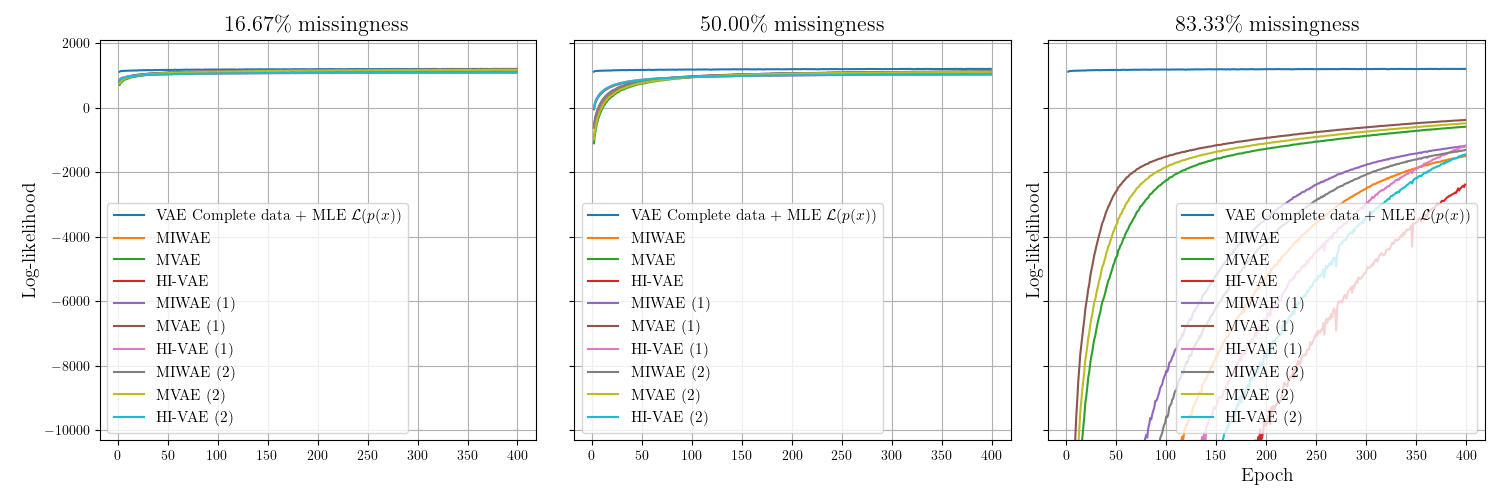

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(15, 5))
axes = axes.flatten()
# axes = [axes]
gs = [1, 3, 5]
# gs = [5]
for i, g in enumerate(gs):
    stats = read_suite_stats(group=g, suite=suite, seed=exp_seed_keys[0], filename='summary.csv')

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (0, 2):
        ylabel = 'Log-likelihood'
    else:
        ylabel=None

    if i in (2, 3):
        xlabel='Epoch'
    else:
        xlabel=None
    
    plot_comparison(axes[i], stats, 
                    x_metric_key='curr_epoch',
                    y_metric_keys=('train_log_lik',),
#                     y_metric_keys=('val_log_lik',),  
# #                     y_metric_keys=('train_log_lik', 'train_entropy', 'val_log_lik'),
                    err_keys=(None,),
#                     err_keys=(None, None),
#                     err_keys=(None, None, None, None),
                    xlabel=xlabel,
                    ylabel=ylabel, 
                    ylim=None)
#                     ylim=(-19.6, -19.1))
#                     ylim=(0, 10))

# axes[0].set_xlim(left=-5, right=255)
# axes[1].set_xlim(left=-5, right=255)
# axes[2].set_xlim(left=-5, right=255)

fig.tight_layout()

##### Avg. over seeds

<IPython.core.display.Javascript object>


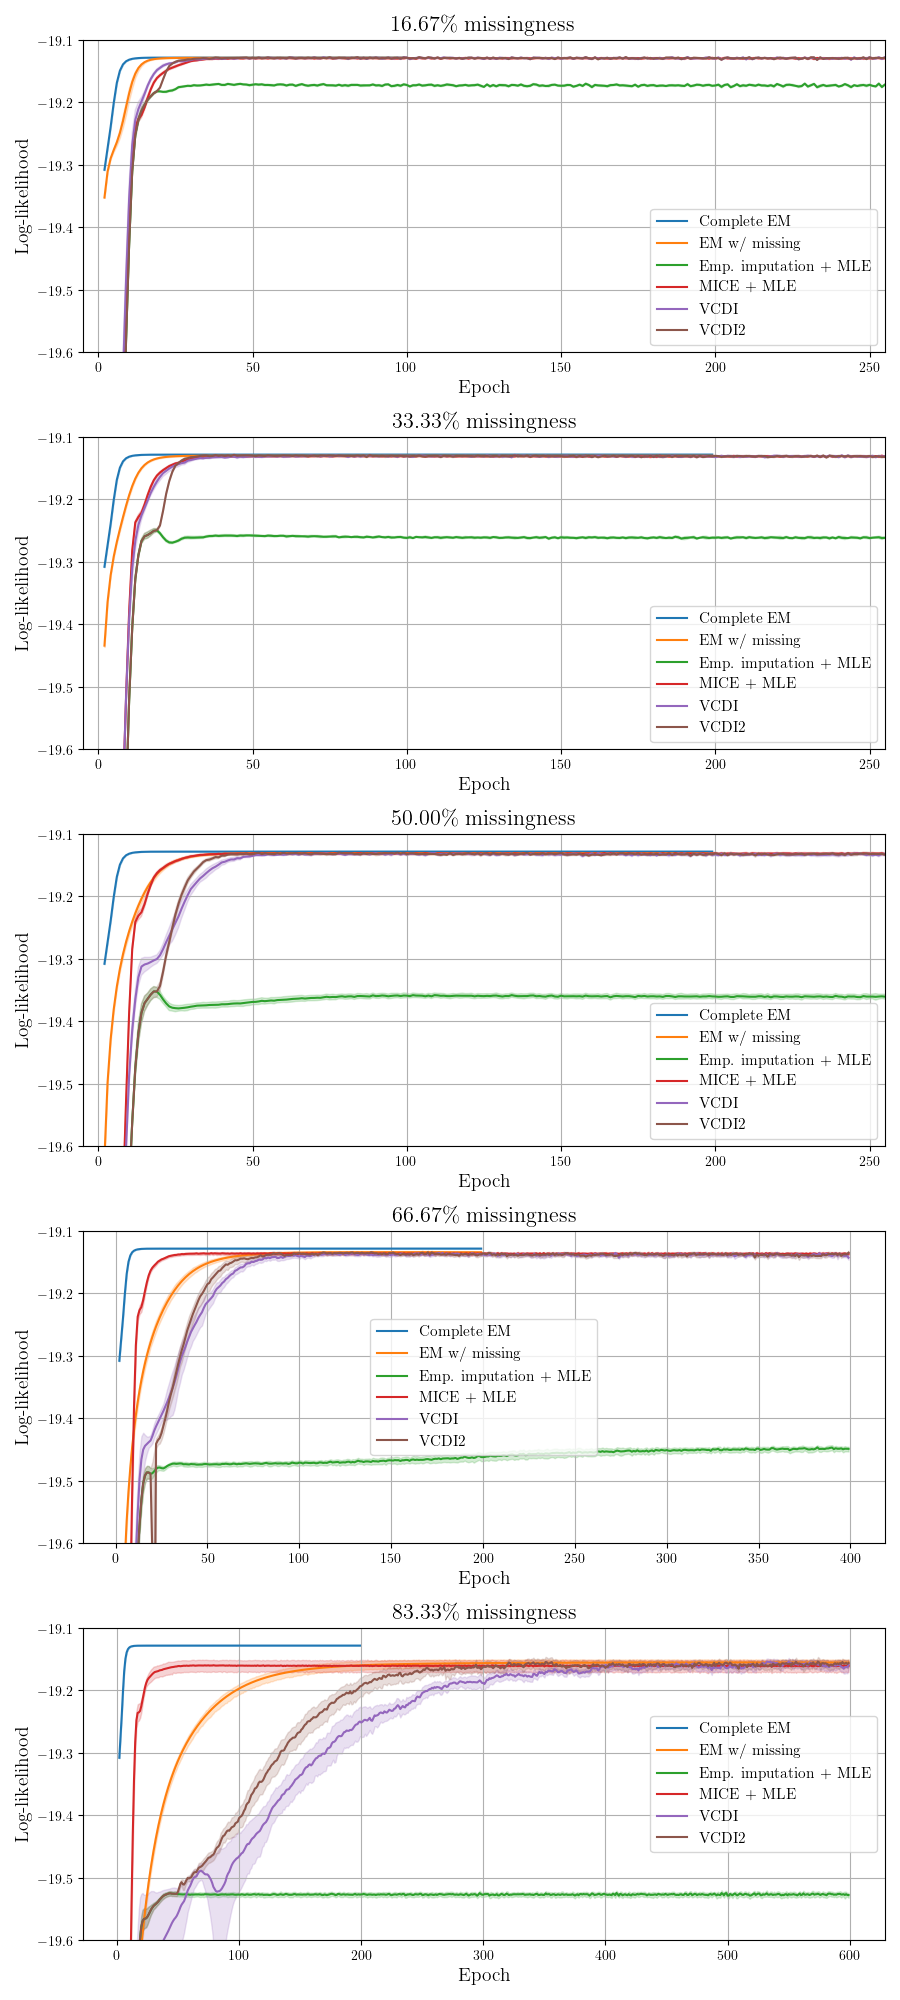

In [73]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharey=True, figsize=(9, 20))
# axes = [axes]
for i, g in enumerate([1, 2, 3, 4, 5]):
    stats = read_suite_stats_all_seeds(group=g, suite=suite, filename='summary.csv')

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (2,):
        xlabel='Epoch'
    else:
        xlabel=None
    plot_seaborn_comparison(axes[i], stats, 
                    x_metric_key='curr_epoch',
                    y_metric_keys=('val_log_lik',),
                    xlabel='Epoch',
                    ylabel='Log-likelihood', 
#                     ylim=None)
                    ylim=(-19.6, -19.1))
#                     ylim=(-26, -17))
#                     ylim=(0, 10))

axes[0].set_xlim(left=-5, right=255)
axes[1].set_xlim(left=-5, right=255)
axes[2].set_xlim(left=-5, right=255)

fig.tight_layout()

#### Log-likelihood vs # $p(x)$ evaluations

In [12]:
suite = {
    'Complete MLE': 'fa_complete_data',
#     'EM w/ missing': 'fa_mcem_joint',
#     'VCDI': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
}

##### Single experiment

<IPython.core.display.Javascript object>


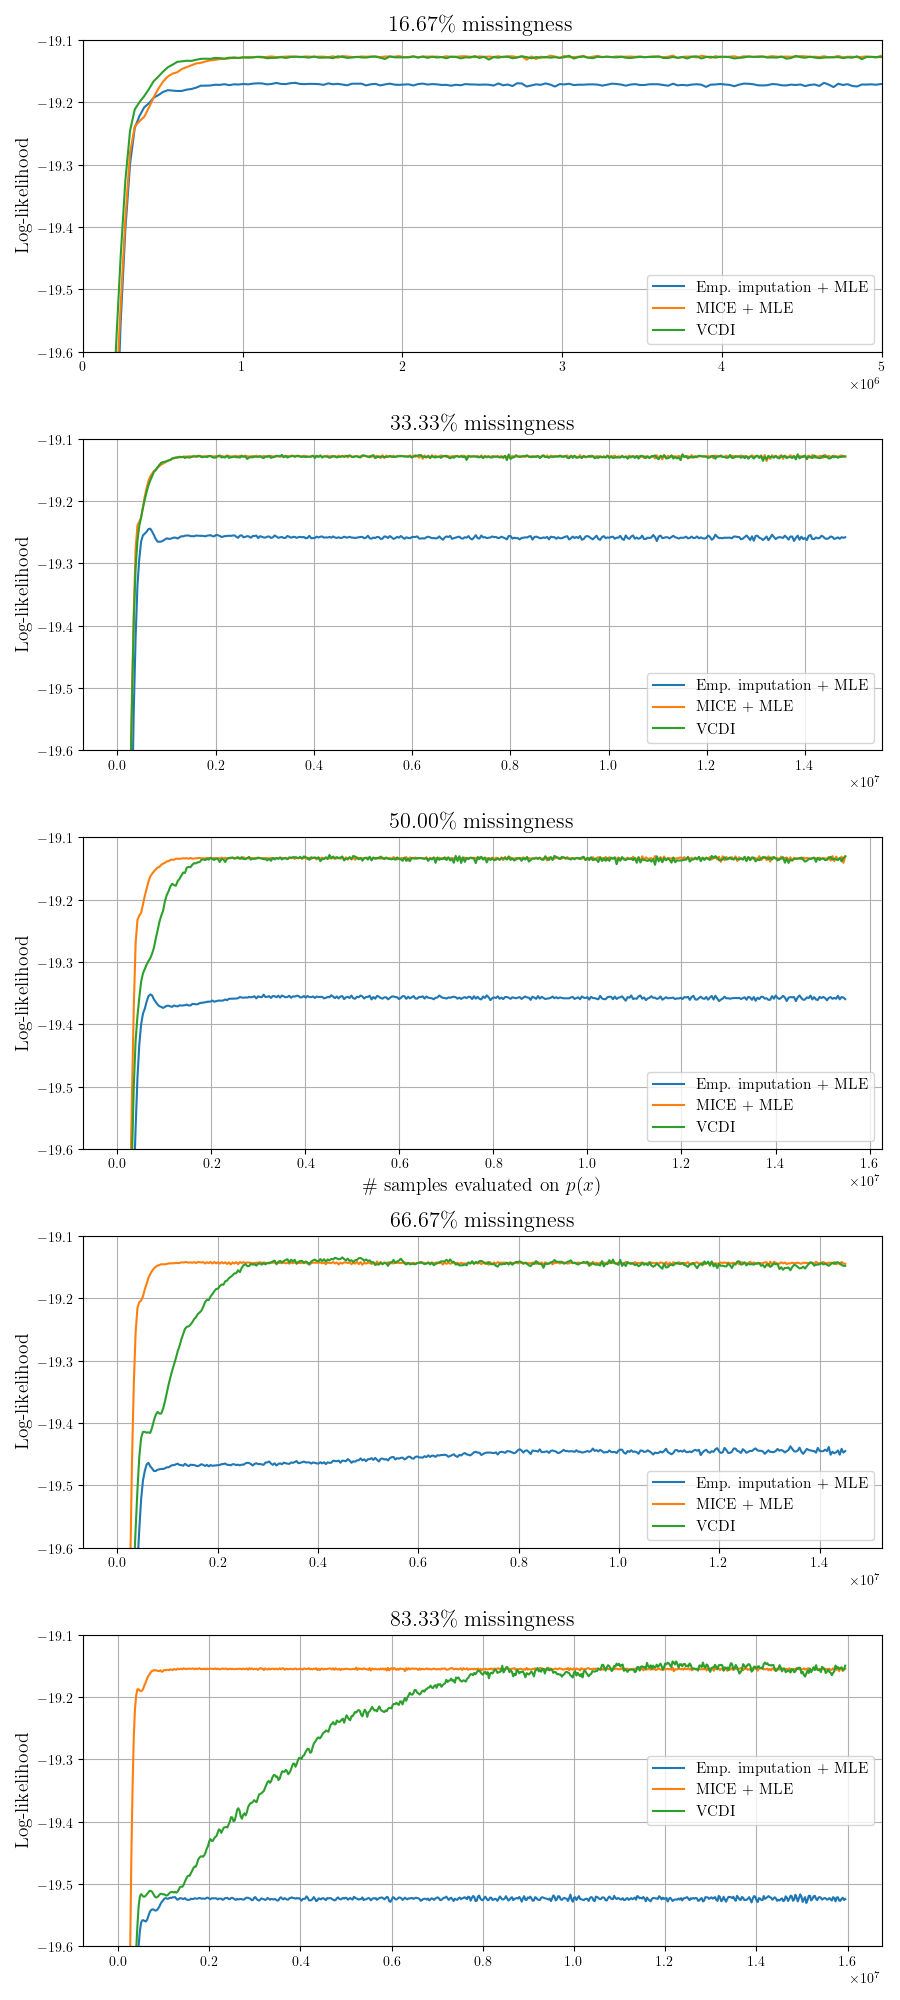

In [13]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharey=True, figsize=(9, 20))
# axes = [axes]
gs = [1, 2, 3, 4, 5]
for i, g in enumerate(gs):
    stats = read_suite_stats(group=g, suite=suite, seed=exp_seed_keys[0], filename='summary.csv')
    for exp, metrics in stats.items():
        metrics['cum_fa_calls'] = np.cumsum(metrics['cum_fa_calls'])
#         metrics['cum_var_calls'] = np.cumsum(metrics['cum_var_calls'])

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (2,):
        xlabel = '\# samples evaluated on $p(x)$'
    else:
        xlabel = None
    plot_comparison(axes[i], stats, 
                    x_metric_key='cum_fa_calls',
                    y_metric_keys=('val_log_lik',),  
# #                     y_metric_keys=('train_log_lik', 'train_entropy', 'val_log_lik'),
                    err_keys=(None,),
#                     err_keys=(None, None),
#                     err_keys=(None, None, None),
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
#                     ylim=None)
                    ylim=(-19.6, -19.1))
#                     ylim=(-26, -17))
#                     ylim=(0, 10))

axes[0].set_xlim(left=-10, right=5e6+10)
# axes[1].set_xlim(left=-10, right=5e6+10)
# axes[2].set_xlim(left=-10, right=5e6+10)

fig.tight_layout()

##### Avg. over seeds

<IPython.core.display.Javascript object>


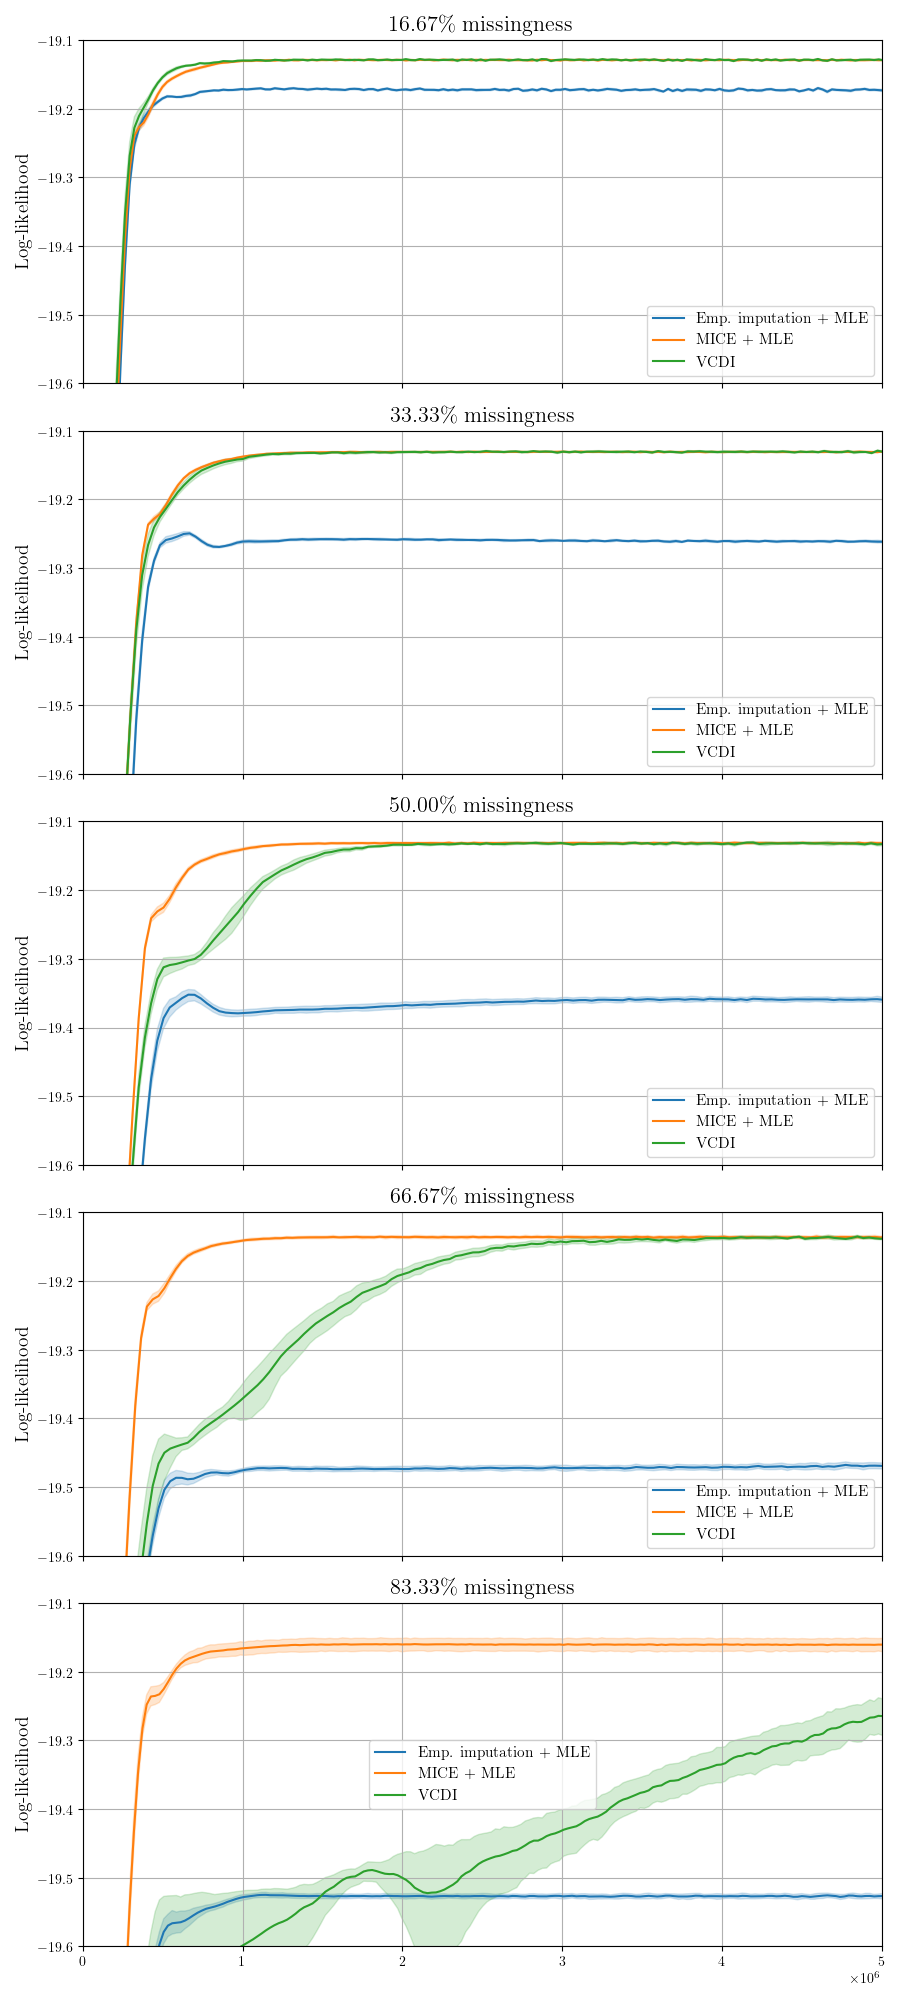

In [14]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharey=True, sharex=True, figsize=(9, 20))
# axes = [axes]
gs = [1, 2, 3, 4, 5]
for i, g in enumerate(gs):
    stats = read_suite_stats_all_seeds(group=g, suite=suite, filename='summary.csv')
    for exp, metrics in stats.items():
        for j in range(len(metrics['cum_fa_calls'])):
            metrics['cum_fa_calls'][j] = np.cumsum(metrics['cum_fa_calls'][j])
        mean_cum_sum = np.mean(np.stack(metrics['cum_fa_calls']), axis=0)
        for j in range(len(metrics['cum_fa_calls'])):
            metrics['cum_fa_calls'][j] = mean_cum_sum

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (2,):
        xlabel = '\# samples evaluated on $p(x)$'
    else:
        xlabel = None
    plot_seaborn_comparison(axes[i], stats, 
                    x_metric_key='cum_fa_calls',
                    y_metric_keys=('val_log_lik',),  
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
#                     ylim=None)
                    ylim=(-19.6, -19.1))
#                     ylim=(-26, -17))

axes[0].set_xlim(left=-10, right=5e6+10)
axes[1].set_xlim(left=-10, right=5e6+10)
axes[2].set_xlim(left=-10, right=5e6+10)

fig.tight_layout()

In [84]:
# fig.savefig('figures/toy_mcar_learning_curves_vs_num_px.pdf', bbox_inches='tight')

#### Log-likelihood vs time

In [21]:
suite = {
    'Complete MLE': 'fa_complete_data',
#     'EM w/ missing': 'fa_mcem_joint',
#     'VCDI': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
}

##### Single experiment

<IPython.core.display.Javascript object>


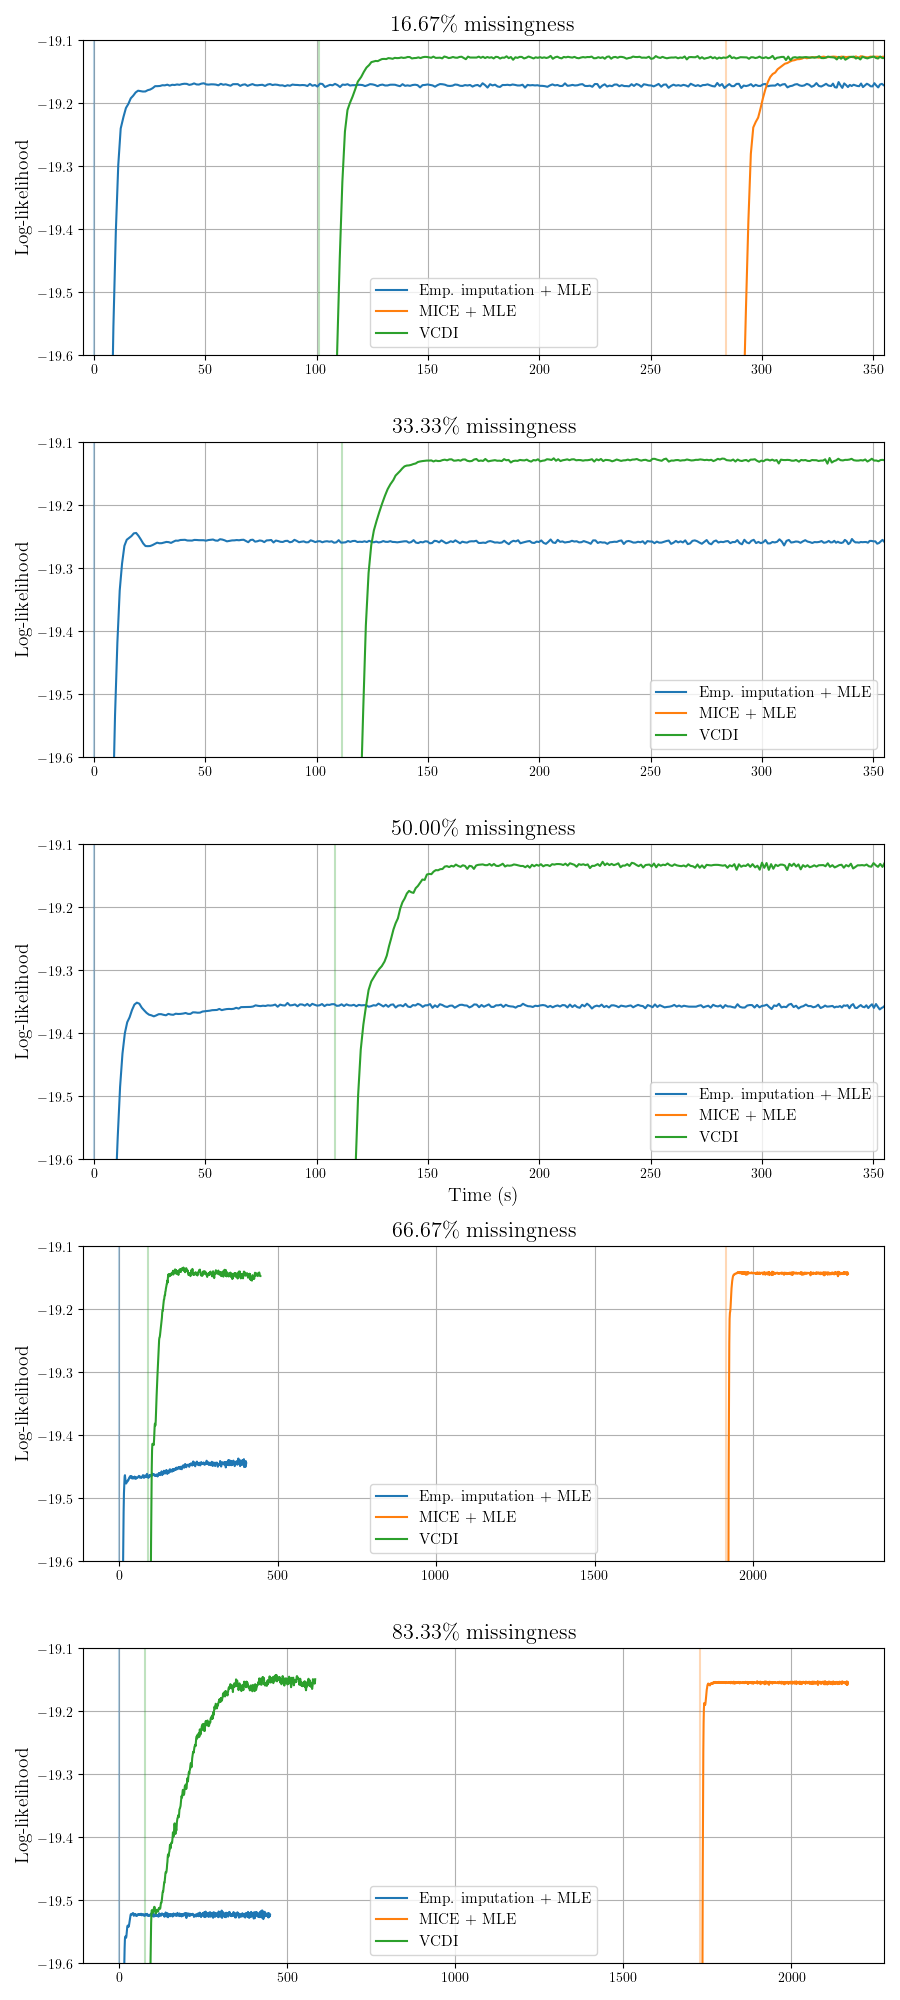

In [15]:
y_metrics = ('val_log_lik',)

fig, axes = plt.subplots(nrows=5, ncols=1, sharey=True, figsize=(9, 20))
# axes = [axes]
gs = [1, 2, 3, 4, 5]
for i, g in enumerate(gs):
    stats = read_suite_stats_with_init(group=g, suite=suite, seed=exp_seed_keys[0])
    v_lines = {}
    for exp, metrics in stats.items():
        metrics['train_time'] = np.cumsum(metrics['train_time'])
        if 'init_time' in metrics['init']:
            init_time = np.sum(metrics['init']['init_time'])
            metrics['train_time'] += init_time
            v_lines[exp] = init_time
        else:
            v_lines[exp] = None

    if i in (2,):
        xlabel = 'Time (s)'
    else:
        xlabel = None
    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    plot_comparison(axes[i], stats, 
                    x_metric_key='train_time',
                    y_metric_keys=y_metrics,  
                    err_keys=(None, ),
                    v_lines=v_lines,
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
                    ylim=(-19.6, -19.1))

axes[0].set_xlim(left=-5, right=355)
axes[1].set_xlim(left=-5, right=355)
axes[2].set_xlim(left=-5, right=355)

fig.tight_layout()

##### Avg. over seeds

<IPython.core.display.Javascript object>


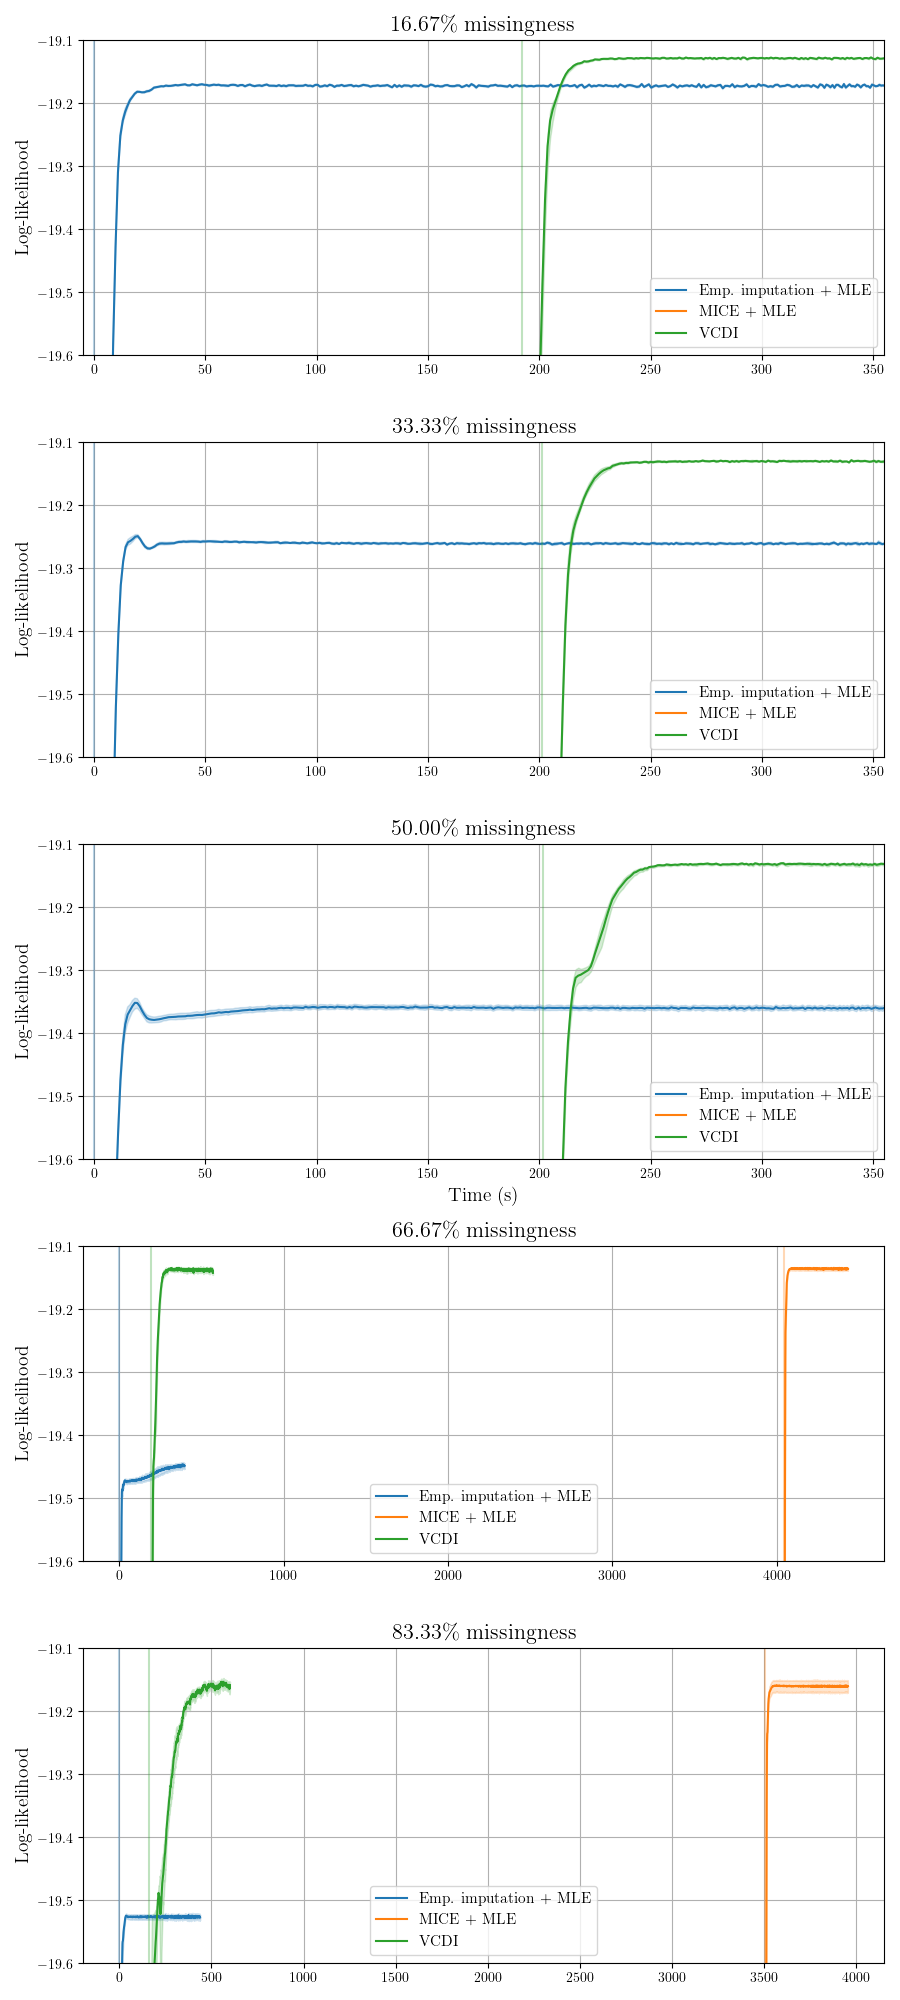

In [16]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharey=True, figsize=(9, 20))
# axes = [axes]
gs = [1,2,3,4,5]
for i, g in enumerate(gs):
    stats = read_suite_stats_with_init_all_seeds(group=g, suite=suite)
    v_lines = {}
    for exp, metrics in stats.items():
        for j in range(len(metrics['train_time'])):
            metrics['train_time'][j] = np.cumsum(metrics['train_time'][j])
        mean_time_cum_sum = np.mean(np.stack(metrics['train_time']), axis=0)
        for j in range(len(metrics['train_time'])):
            metrics['train_time'][j] = mean_time_cum_sum.copy()
            
        if 'init_time' in metrics['init']:
            for j in range(len(metrics['init']['init_time'])):
                metrics['init']['init_time'][j] = np.cumsum(metrics['init']['init_time'][j])
            mean_init_time_cum_sum = np.mean(np.stack(metrics['init']['init_time']), axis=0)
            init_time = np.sum(mean_init_time_cum_sum)
            for j in range(len(metrics['train_time'])):
                metrics['train_time'][j] += init_time

            v_lines[exp] = init_time
        else:
            v_lines[exp] = None

    if i in (2,):
        xlabel = 'Time (s)'
    else:
        xlabel = None
    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    plot_seaborn_comparison(axes[i], stats, 
                    x_metric_key='train_time',
                    y_metric_keys=('val_log_lik',),  
                    v_lines=v_lines,
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
                    ylim=(-19.6, -19.1))

axes[0].set_xlim(left=-5, right=355)
axes[1].set_xlim(left=-5, right=355)
axes[2].set_xlim(left=-5, right=355)

fig.tight_layout()

#### Log-likelihood vs # var. model evaluations

In [17]:
suite = {
    'Complete MLE': 'fa_complete_data',
#     'EM w/ missing': 'fa_mcem_joint',
#     'VCDI': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
}

##### Single experiment

<IPython.core.display.Javascript object>


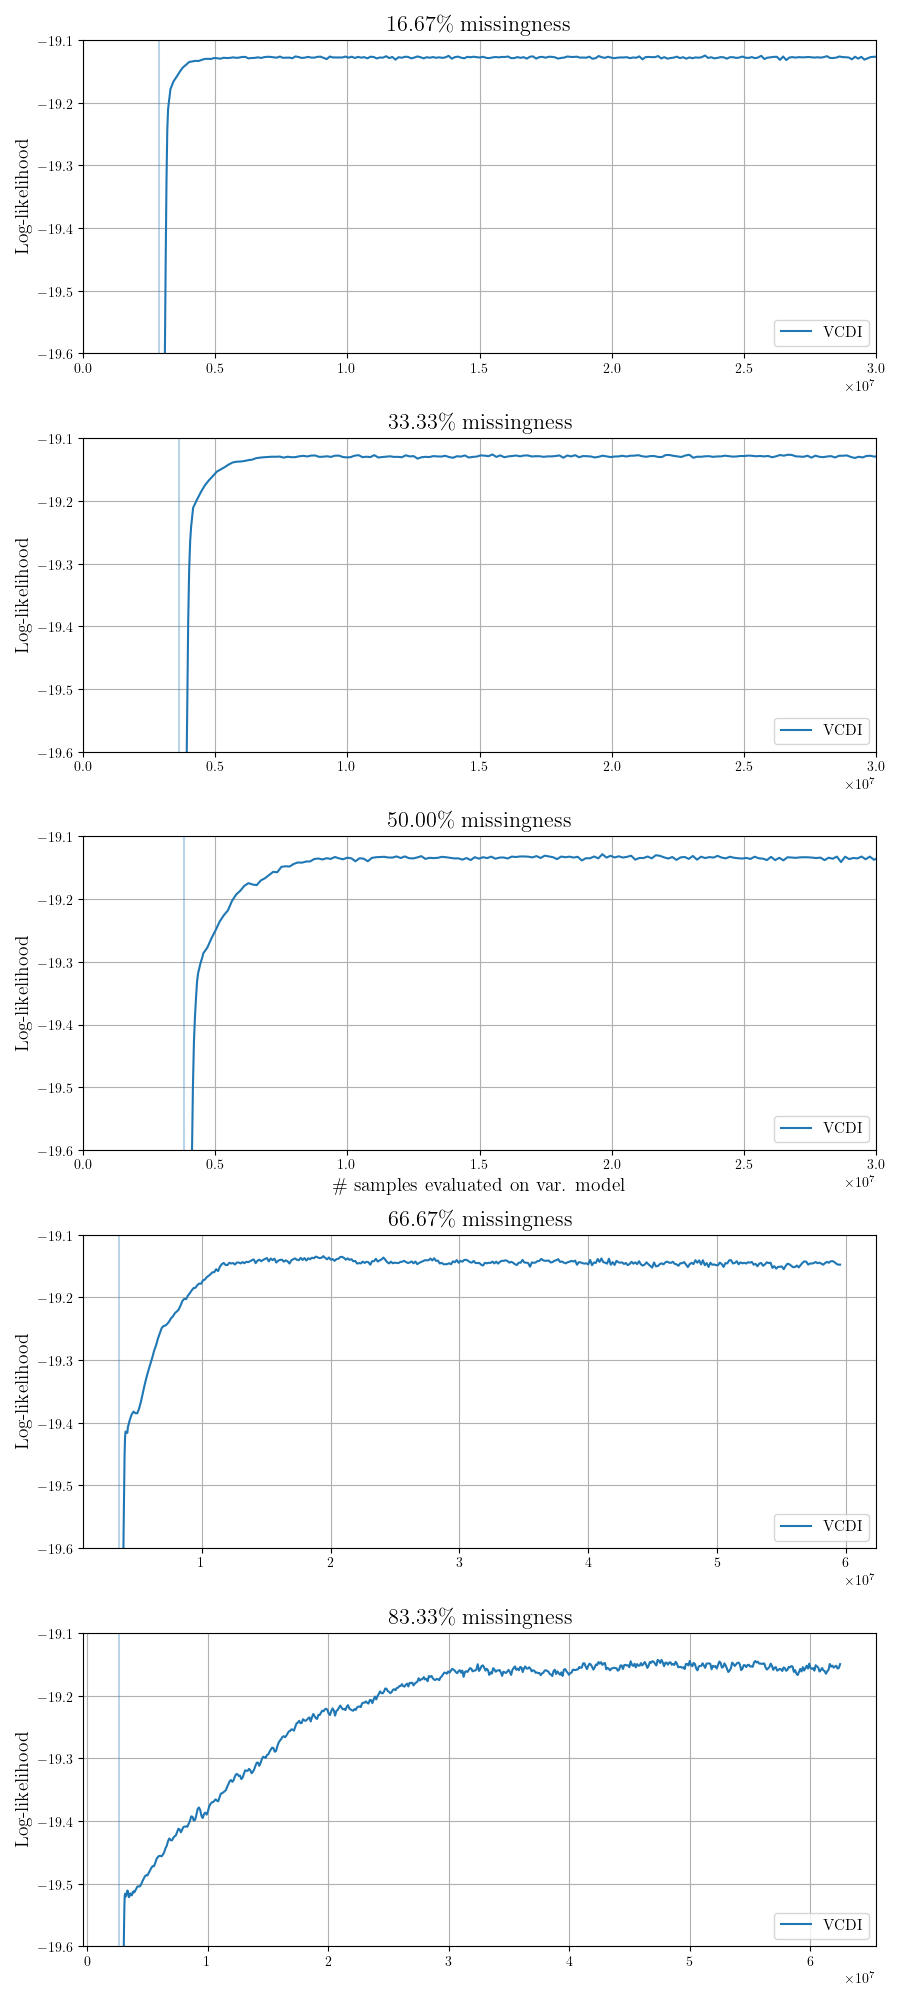

In [18]:
fig, axes = plt.subplots(nrows=5, ncols=1, sharey=True, figsize=(9, 20))
# axes = [axes]
gs = [1,2,3,4,5]
for i, g in enumerate(gs):
    stats = read_suite_stats_with_init(group=g, suite=suite, seed=exp_seed_keys[0])
    v_lines = {}
    for exp, metrics in stats.items():
        metrics['cum_var_calls'] = np.cumsum(metrics['cum_var_calls'])
        if 'cum_var_calls' in metrics['init']:
            init_calls = np.sum(metrics['init']['cum_var_calls'])
            metrics['cum_var_calls'] += init_calls
            v_lines[exp] = init_calls
        else:
            v_lines[exp] = None
    
    if i in (2,):
        xlabel = '\# samples evaluated on var. model'
    else:
        xlabel = None
    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    plot_comparison(axes[i], stats, 
                    x_metric_key='cum_var_calls',
                    y_metric_keys=('val_log_lik',),  
                    err_keys=(None,),
                    v_lines=v_lines,
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
                    ylim=(-19.6, -19.1))

axes[0].set_xlim(left=-10, right=3e7)
axes[1].set_xlim(left=-10, right=3e7)
axes[2].set_xlim(left=-10, right=3e7)

fig.tight_layout()

##### Avg. over seeds

<IPython.core.display.Javascript object>


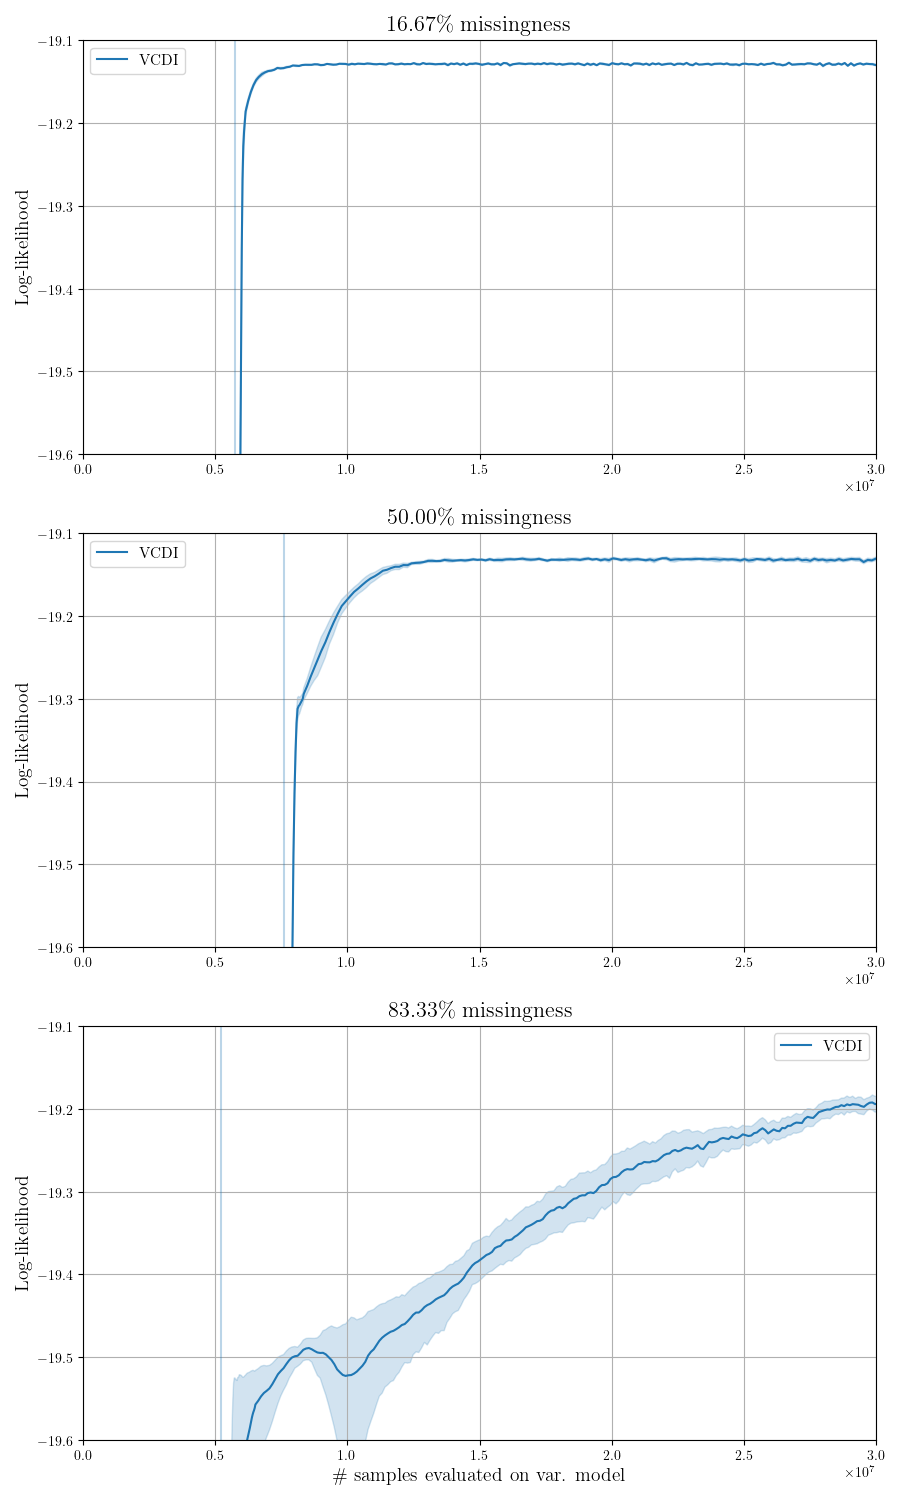

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharey=True, figsize=(9, 15))
# axes = [axes]
for i, g in enumerate([1, 3, 5]):
    stats = read_suite_stats_with_init_all_seeds(group=g, suite=suite)
    v_lines = {}
    for exp, metrics in stats.items():
        for j in range(len(metrics['cum_var_calls'])):
            metrics['cum_var_calls'][j] = np.cumsum(metrics['cum_var_calls'][j])
        mean_call_cum_sum = np.mean(np.stack(metrics['cum_var_calls']), axis=0)
        for j in range(len(metrics['cum_var_calls'])):
            metrics['cum_var_calls'][j] = mean_call_cum_sum.copy()
        
        if 'cum_var_calls' in metrics['init']:
            for j in range(len(metrics['init']['cum_var_calls'])):
                metrics['init']['cum_var_calls'][j] = np.cumsum(metrics['init']['cum_var_calls'][j])
            mean_init_calls_cum_sum = np.mean(np.stack(metrics['init']['cum_var_calls']), axis=0)
            init_calls = np.sum(mean_init_calls_cum_sum)
            for j in range(len(metrics['cum_var_calls'])):
                metrics['cum_var_calls'][j] += init_calls

            v_lines[exp] = init_calls
        else:
            v_lines[exp] = None
    
    if i in (2,):
        xlabel = '\# samples evaluated on var. model'
    else:
        xlabel = None
    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    plot_seaborn_comparison(axes[i], stats, 
                    x_metric_key='cum_var_calls',
                    y_metric_keys=('val_log_lik',),  
                    v_lines=v_lines,
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
                    ylim=(-19.6, -19.1))

axes[0].set_xlim(left=-10, right=3e7)
axes[1].set_xlim(left=-10, right=3e7)
axes[2].set_xlim(left=-10, right=3e7)

fig.tight_layout()

### Var. model pretraining learning curve

In [22]:
suite = {
#     'Var': 'var_pretraining_1e-3',
    'Shared Var': 'svar_pretraining',
#     'Var test': 'var_pretraining_test',
}

<IPython.core.display.Javascript object>


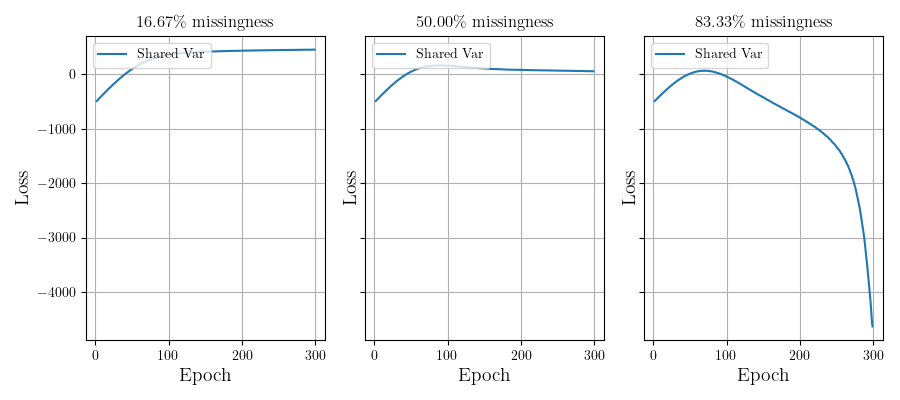

In [28]:
y_metrics = ('val_log_lik',#)
            'val_log_lik_0',
            'val_log_lik_1',
            'val_log_lik_2',
            'val_log_lik_3',
            'val_log_lik_4',
            'val_log_lik_5')
err_metrics = (None, None, None, None, None, None, None)
# metric_labels = ('log\_lik',#)
#                  'log\_lik dim(0)',
#                  'log\_lik dim(1)',
#                  'log\_lik dim(2)',
#                  'log\_lik dim(3)',
#                  'log\_lik dim(4)',
#                  'log\_lik dim(5)',)
metric_labels = None

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(9, 4))
# axes = [axes]
gs = [1, 3, 5]
for i, g in enumerate(gs):
    axes[i].set(title=f'{g/6*100:.2f}\% missingness')
    stats = read_suite_stats(group=g, suite=suite, seed=exp_seed_keys[0], filename='summary.csv')
    
    plot_comparison(axes[i], stats, 
                    x_metric_key='curr_epoch',
                    y_metric_keys=y_metrics,  
                    err_keys=err_metrics,
                    metric_labels=metric_labels,
                    xlabel='Epoch',
                    ylabel='Loss', 
                    ylim=None,
                    colors_instead_styles=False)

    axes[i].legend(loc='upper left')

fig.tight_layout()